In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import safetensors
from safetensors import safe_open
import torch
from pathlib import Path
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Baseline

In [4]:
feature_path = "/data/lux70/data/pfam/features/all.pt"
with safe_open(feature_path, "pt") as f:
    features = f.get_tensor('features')

print(features.shape)

NUM_TO_EVAL = 512
idxs = np.arange(NUM_TO_EVAL * 2)
np.random.shuffle(idxs)

idxs1 = idxs[:NUM_TO_EVAL]
idxs2 = idxs[NUM_TO_EVAL:]

gt_x1 = features[idxs1].numpy()
gt_x2 = features[idxs2].numpy()

torch.Size([11886, 32])


In [5]:
from plaid.evaluation import parmar_kid, parmar_fid, sinkhorn, ConditionalDistributionDistance

In [6]:
uncond_gt_fid = parmar_fid(gt_x1, gt_x2)
print(uncond_gt_fid)

0.004427324210236727


In [7]:
parmar_kid(gt_x1, gt_x2)

-3.0023683074134057e-05

In [8]:
sinkhorn(gt_x1, gt_x2)

0.09390160464681685

### Unconditional to Random

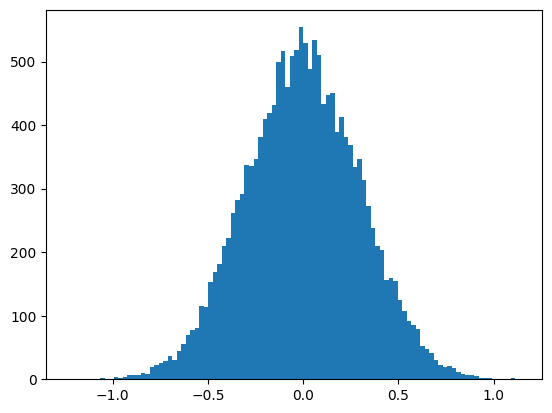

In [9]:
# from scipy.stats import beta

# # Beta distribution parameters can be tweaked for a Gaussian-like shape
# alpha, beta_param = 8, 8
# samples = beta(alpha, beta_param).rvs(1000)

# # Rescale to [-1, 1]
# bounded_samples = 2 * samples - 0.9
# print(bounded_samples.shape)
# _ = plt.hist(bounded_samples.flatten(),bins=100)

random_arr = np.random.normal(0, 0.3, (512, 32))
_ = plt.hist(random_arr.flatten(), bins=100)

In [10]:
random_fid = parmar_fid(random_arr, gt_x1)
print(random_fid)

3.64562124110458


In [11]:
parmar_fid(random_arr, gt_x2)

3.6613143722900707

In [12]:
sinkhorn(random_arr, gt_x2)

4.330964043618719

# Unconditional generation performance

# Amass Conditional FID

In [13]:
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.
Creating ESMFold embedding only model...
ESMFold embedding only model created in 30.02 seconds


In [14]:
from pathlib import Path
import glob
import numpy as np
import torch
import os

samples_dir = Path("/data/lux70/plaid/artifacts/samples/5j007z42/val_dist") #/data/lux70/plaid/artifacts/samples/5j007z42/function_cond/v1")

In [15]:
cond_codes = list(filter(lambda x: "s3" in x, os.listdir(samples_dir)))

In [18]:
def cond_code_to_idx(cond_code: str):
    vals = cond_code.split("_")
    return int(vals[0][1:]), int(vals[1][1:])

condgen_to_true = {}
uncond_to_true = {}

batch_size = 128
metric = "sinkhorn"

def npy(x):
    try:
        return np.array(x)
    except:
        return x

def sinkhorn(x,y):
    x, y = npy(x), npy(y)
    import ot

    M = ot.dist(x,y)
    wasserstein_dist = ot.emd2([], [], M)
    return wasserstein_dist


for i, cond_code in enumerate(cond_codes):
    function_idx, _ = cond_code_to_idx(cond_code)
    
    try:
        fpath = samples_dir / cond_code / "latent.npz"
        print(fpath)

        cond_fid = ConditionalDistributionDistance(
            function_idx=function_idx,
            organism_idx=None,
            cheap_pipeline=cheap_pipeline,
            batch_size=batch_size,
            max_seq_len=256,
            max_eval_samples=256,
            min_samples=16,
            metric=metric
        )
        
        with np.load(fpath, allow_pickle=True) as f:
            x = f['samples'].astype(np.float32)

        feat = x[:, -1, :, :] # take last timestep only
        feat = feat.mean(axis=1)
        res = cond_fid.run(feat)
        print(cond_code, f"Generated <-> GT {metric}:", res)

        condgen_to_true[cond_code] = res

        # also try what happens if you do ground truth unconditional to conditional
        # res = parmar_fid(feat, gt_x1)
        # res = parmar_fid(cond_fid.real, gt_x1)
        N = min(x.shape[0], 256)
        real, uncond_real = cond_fid.real[:N], gt_x1[:N]
        res = sinkhorn(real, uncond_real)
        
        uncond_to_true[cond_code] = res
        print(cond_code, f"Random Real <-> GT {metric}:", res)
        
    except Exception as e:
        print(e)
        continue
            


/data/lux70/plaid/artifacts/samples/5j007z42/val_dist/f40_o1326_l112_s3/latent.npz
Found 15091 samples for this condition.
f40_o1326_l112_s3 Generated <-> GT sinkhorn: 0.5976401343941689
f40_o1326_l112_s3 Random Real <-> GT sinkhorn: 0.3305380381643772
/data/lux70/plaid/artifacts/samples/5j007z42/val_dist/f296_o1326_l68_s3/latent.npz
Found 3561 samples for this condition.
f296_o1326_l68_s3 Generated <-> GT sinkhorn: 0.35643448680639267
f296_o1326_l68_s3 Random Real <-> GT sinkhorn: 0.425365325063467
/data/lux70/plaid/artifacts/samples/5j007z42/val_dist/f2107_o1326_l196_s3/latent.npz
Found 323 samples for this condition.
f2107_o1326_l196_s3 Generated <-> GT sinkhorn: 0.09775006026029587
f2107_o1326_l196_s3 Random Real <-> GT sinkhorn: 0.7229488082230091
/data/lux70/plaid/artifacts/samples/5j007z42/val_dist/f35_o1326_l112_s3/latent.npz
Found 57056 samples for this condition.
f35_o1326_l112_s3 Generated <-> GT sinkhorn: 0.3175817131996155
f35_o1326_l112_s3 Random Real <-> GT sinkhorn: 0.4

# Plot

In [57]:
# turn into dataframe
df1 = pd.DataFrame(list(condgen_to_true.items()), columns=['Key', 'condgen_to_true'])
df2 = pd.DataFrame(list(uncond_to_true.items()), columns=['Key', 'uncond_to_true'])
combined_df = pd.merge(df1, df2, on='Key')
combined_df["GO_idx"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[0])
combined_df["organism_index"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[1])

# attach GO metadata
go_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
combined_df = combined_df.merge(go_df)

# combined_df = combined_df.sort_values(by="count")
combined_df['delta'] = combined_df.condgen_to_true - combined_df.uncond_to_true
combined_df['log_count'] = np.log(combined_df['count'].values)
combined_df = combined_df.sort_values(by="delta")

In [73]:
combined_df['length'] = combined_df.Key.map(lambda s: int(s.split("_")[2][1:]))

In [74]:
combined_df

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta,log_count,length
172,f1479_o1326_l160_s3,0.049092,0.784321,1479,1326,646,circadian rhythm,PF06529,GO:0007623,process,3,-0.735229,1.098612,160
448,f671_o1326_l16_s3,0.191263,0.881690,671,1326,525,calmodulin binding,PF02063,GO:0005516,function,10,-0.690427,2.302585,16
229,f2120_o1326_l156_s3,0.096467,0.775742,2120,1326,356,acrosome reaction,PF15754,GO:0007340,process,1,-0.679276,0.000000,156
371,f453_o1326_l48_s3,0.307593,0.969686,453,1326,1362,nucleosome,PF01254,GO:0000786,component,4,-0.662093,1.386294,48
311,f2079_o1326_l100_s3,0.091799,0.750634,2079,1326,268,RNA polymerase transcription factor SL1 complex,PF15333,GO:0005668,component,1,-0.658835,0.000000,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,f140_o1326_l128_s3,0.769974,0.350965,140,1326,2125,tryptophan synthase activity,PF00290,GO:0004834,function,1,0.419008,0.000000,128
270,f93_o1326_l68_s3,0.817876,0.386167,93,1326,2049,thiamine pyrophosphate binding,PF00205,GO:0030976,function,3,0.431709,1.098612,68
4,f254_o1326_l172_s3,0.934004,0.494651,254,1326,2207,voltage-gated chloride channel activity,PF00654,GO:0005247,function,1,0.439353,0.000000,172
322,f51_o1326_l124_s3,0.838061,0.363284,51,1326,2120,triose-phosphate isomerase activity,PF00121,GO:0004807,function,1,0.474777,0.000000,124


<Axes: >

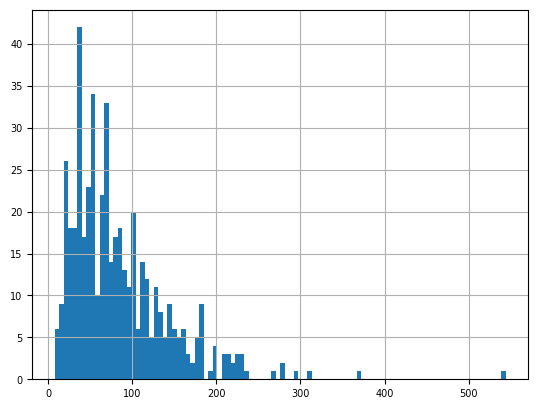

In [76]:
combined_df.length.hist(bins=100)

In [35]:
# combined_df.to_csv("function_cond_sinkhorn.csv", index=False)

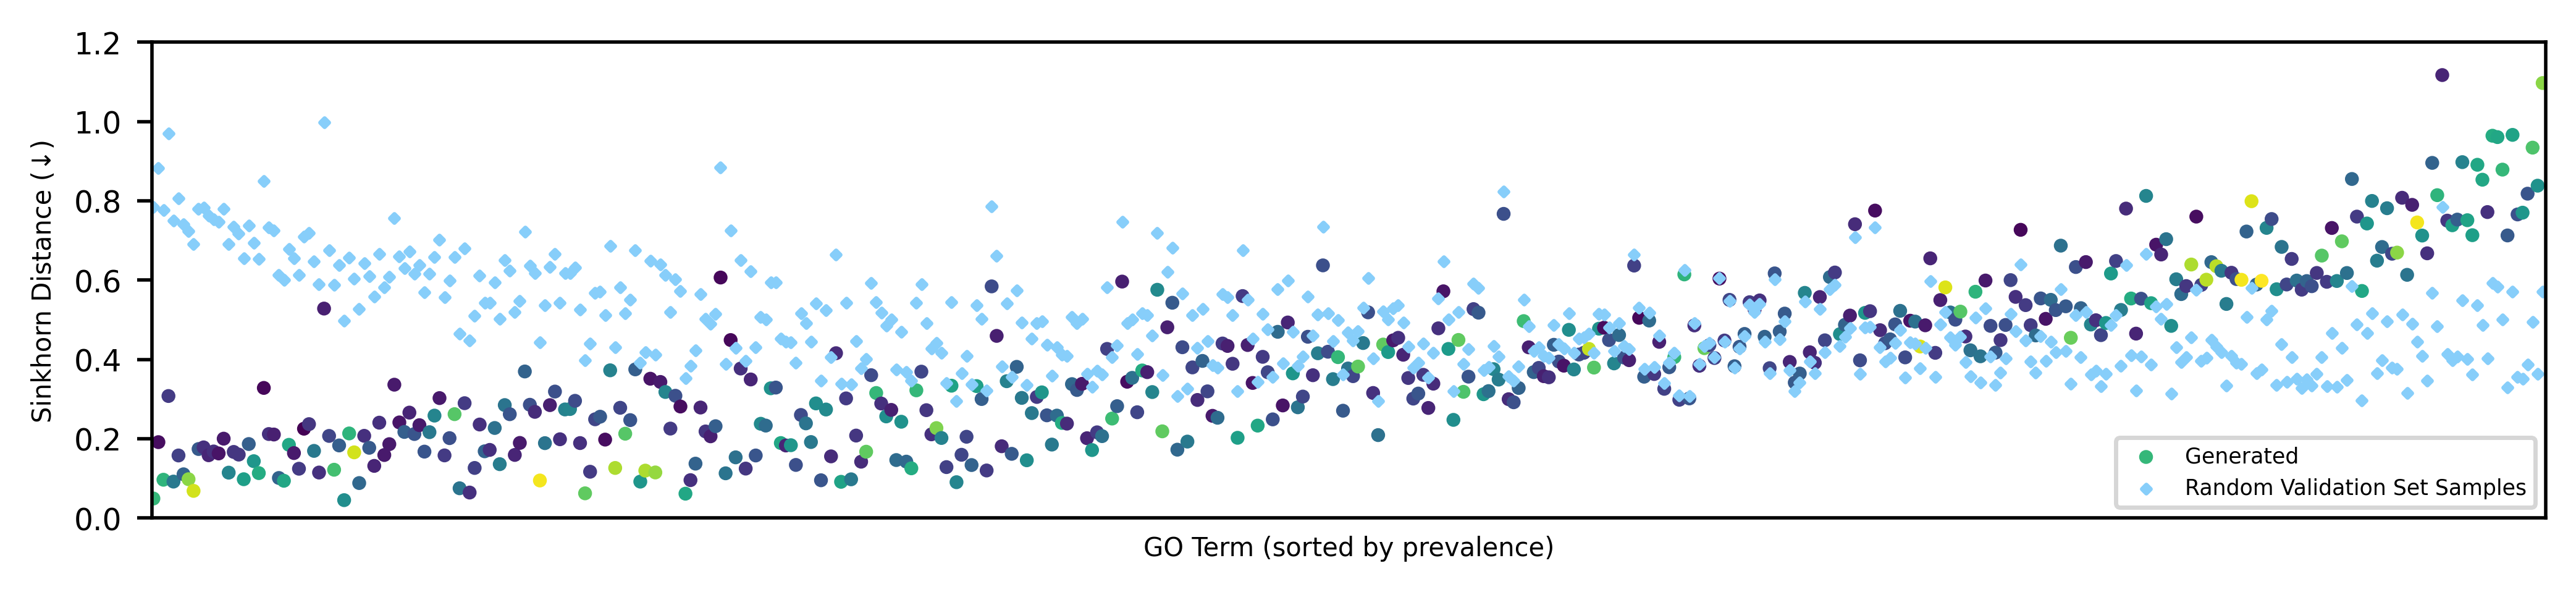

In [86]:
import textwrap
plt.rcParams['font.size'] = 7

from matplotlib import cm
from matplotlib.colors import Normalize

# values = np.log(cdf['count'])
# values = np.log(cdf['length'])
values = cdf['length']
norm = Normalize(vmin=min(values), vmax=max(values))

# cdf = cdf.sort_values(by="condgen_to_true")
# cdf = cdf.sort_values(by="count")
cdf = cdf.sort_values(by="delta")

colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
colors = colormap(norm(values))


fig, ax = plt.subplots(1, 1, dpi=500, figsize=(10,2))
ax.scatter(np.arange(len(cdf)), cdf['condgen_to_true'].values, label="Generated", s=5, c=colors)
# ax.scatter(np.arange(len(cdf)), cdf['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(cdf)), cdf['uncond_to_true'].values, label="Random Validation Set Samples",s=2, c="lightskyblue", marker="D")

ax.set_xlim(-0.3, len(cdf) - 0.4)

# x_labels = cdf.GO_term.values
# wrapped_labels = ['\n'.join(textwrap.wrap(label, width=25)) for label in x_labels]

# ax.set_xticks(ticks=np.arange(len(cdf)), labels=wrapped_labels, rotation=90, fontsize=2)
ax.set_xticks(ticks=[],labels=[])

# ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
# ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_ylim(0,1.2)
ax.set_xlabel("GO Term (sorted by prevalence)", fontsize=6)
ax.set_ylabel("Sinkhorn Distance (↓)", fontsize=6)

plt.legend(fontsize=5)

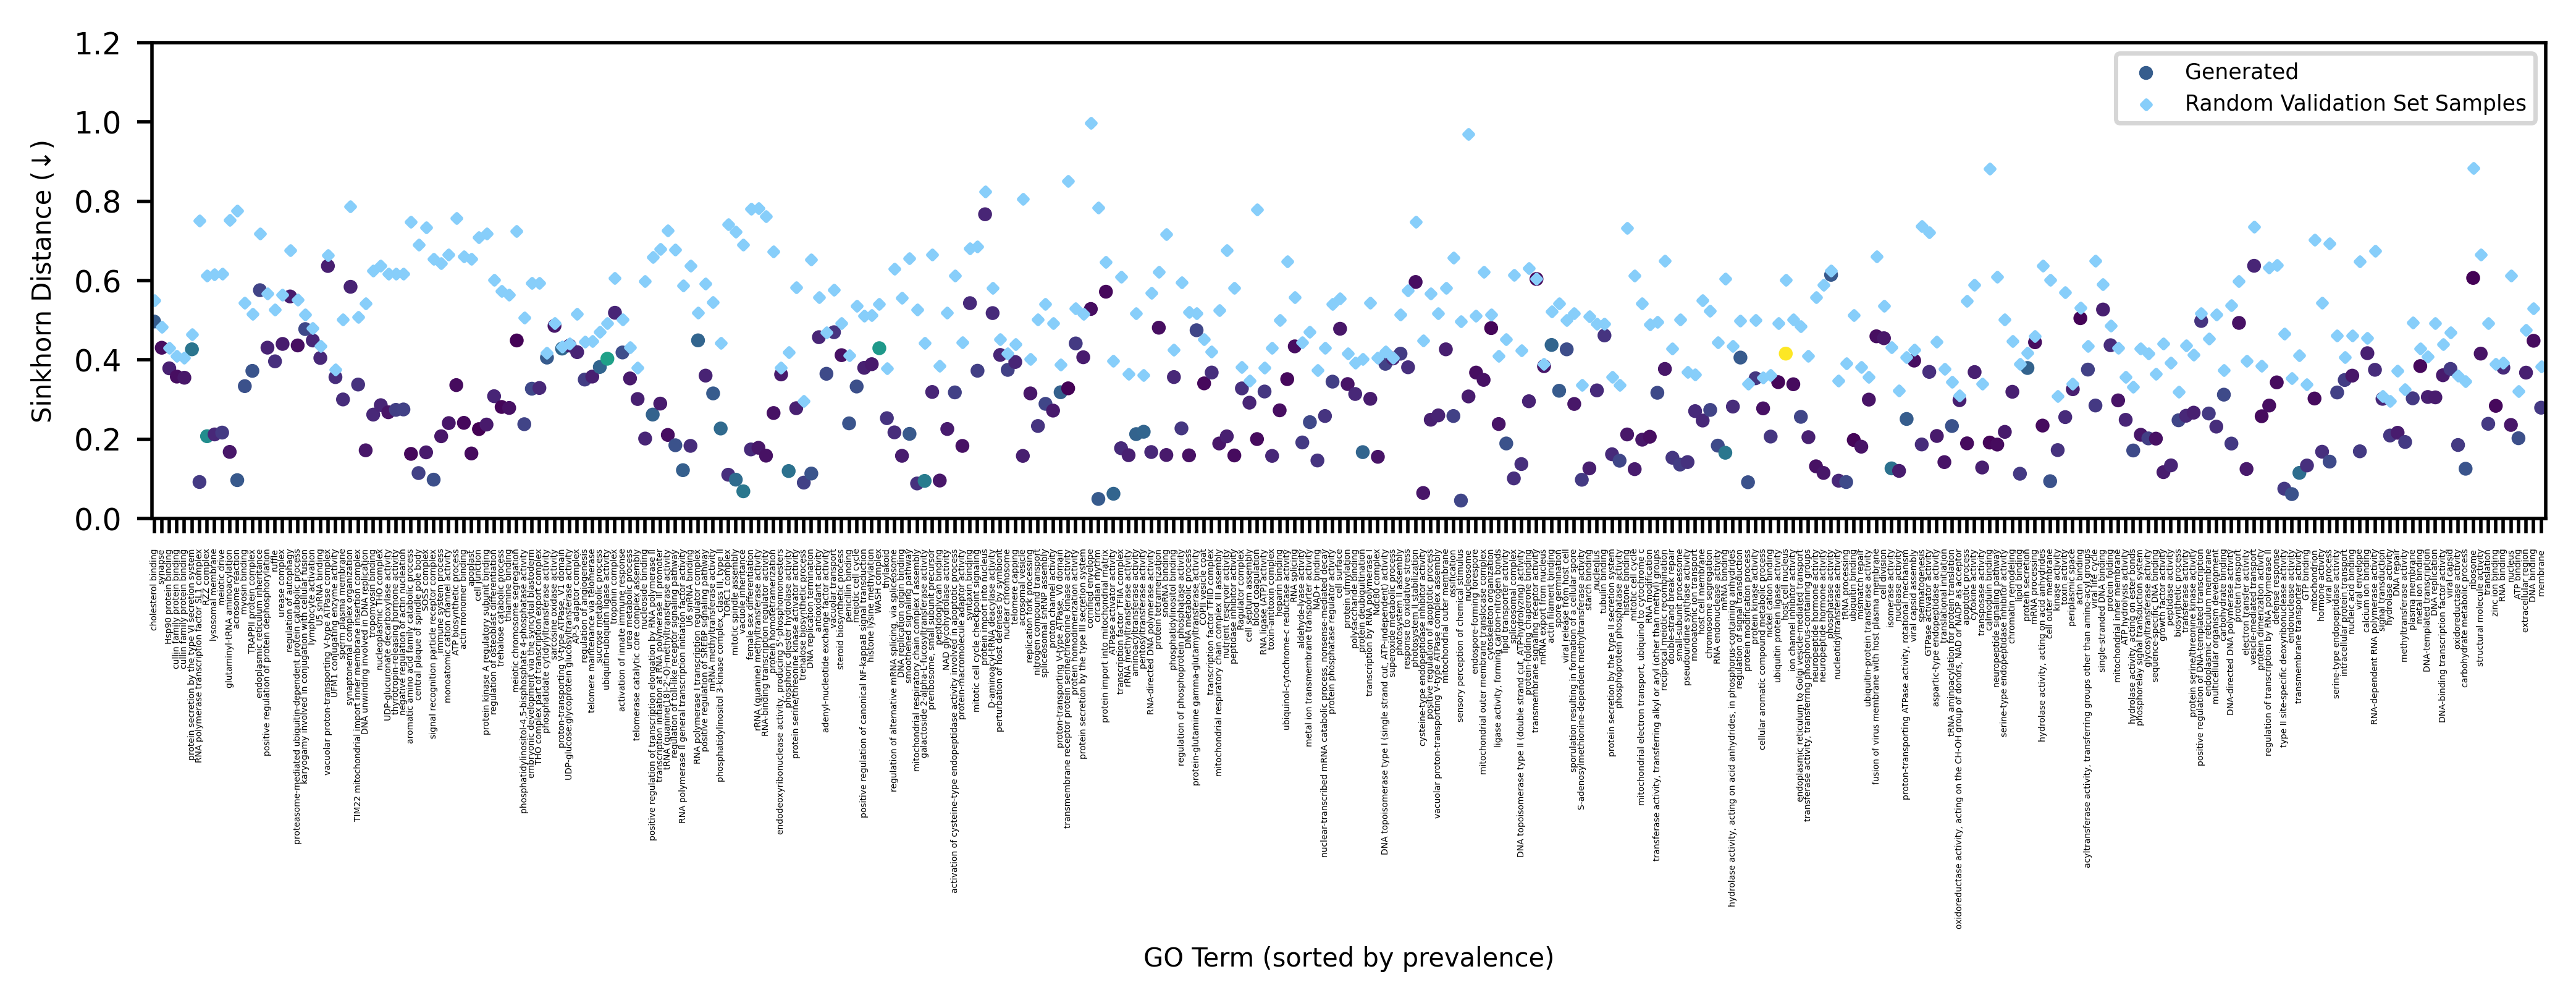

In [88]:
import textwrap
plt.rcParams['font.size'] = 7

from matplotlib import cm
from matplotlib.colors import Normalize

tmpdf = combined_df[combined_df.delta < 0]
# values = np.log(tmpdf['count'])
values = tmpdf['length']
norm = Normalize(vmin=min(values), vmax=max(values))

# tmpdf = tmpdf.sort_values(by="condgen_to_true")
# tmpdf = tmpdf.sort_values(by="count")
# tmpdf = tmpdf.sort_values(by="delta")

colormap = cm.viridis
colors = colormap(norm(values))


fig, ax = plt.subplots(1, 1, dpi=500, figsize=(10,2))
ax.scatter(np.arange(len(tmpdf)), tmpdf['condgen_to_true'].values, label="Generated", s=5, c=colors)
ax.scatter(np.arange(len(tmpdf)), tmpdf['uncond_to_true'].values, label="Random Validation Set Samples",s=2, c="lightskyblue", marker="D")

ax.set_xlim(-0.3, len(tmpdf) - 0.4)

x_labels = tmpdf.GO_term.values
# wrapped_labels = ['\n'.join(textwrap.wrap(label, width=25)) for label in x_labels]

ax.set_xticks(ticks=np.arange(len(tmpdf)), labels=x_labels, rotation=90, fontsize=2)
# ax.set_xticks(ticks=[],labels=[])

# ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
# ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_ylim(0,1.2)
ax.set_xlabel("GO Term (sorted by prevalence)", fontsize=6)
ax.set_ylabel("Sinkhorn Distance (↓)", fontsize=6)

plt.legend(fontsize=5)

<Axes: xlabel='uncond_to_true', ylabel='condgen_to_true'>

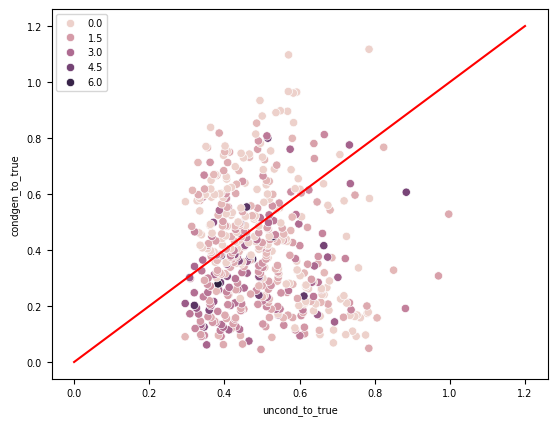

In [59]:
sns.scatterplot(data=combined_df, x="uncond_to_true", y="condgen_to_true",hue='log_count')

dots = x=np.arange(0,1.3,0.1)
sns.lineplot(x=dots, y=dots, c="red")

SignificanceResult(statistic=0.019531040406157787, pvalue=0.668205075488539)
SignificanceResult(statistic=-0.28928488913936906, pvalue=8.754895760166902e-11)


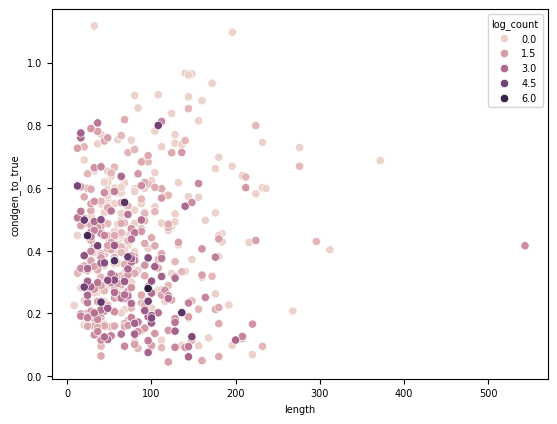

In [102]:
sns.scatterplot(data=combined_df, x="length", y="condgen_to_true",hue='log_count')
from scipy.stats import spearmanr
print(spearmanr(combined_df.length, combined_df.condgen_to_true))
print(spearmanr(combined_df['count'].values, combined_df.condgen_to_true.values))

In [98]:
combined_df[combined_df.delta < 0].sort_values(by="delta", ascending=True).head(n=30)

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta,log_count,length
172,f1479_o1326_l160_s3,0.049092,0.784321,1479,1326,646,circadian rhythm,PF06529,GO:0007623,process,3,-0.735229,1.098612,160
448,f671_o1326_l16_s3,0.191263,0.881690,671,1326,525,calmodulin binding,PF02063,GO:0005516,function,10,-0.690427,2.302585,16
229,f2120_o1326_l156_s3,0.096467,0.775742,2120,1326,356,acrosome reaction,PF15754,GO:0007340,process,1,-0.679276,0.000000,156
371,f453_o1326_l48_s3,0.307593,0.969686,453,1326,1362,nucleosome,PF01254,GO:0000786,component,4,-0.662093,1.386294,48
311,f2079_o1326_l100_s3,0.091799,0.750634,2079,1326,268,RNA polymerase transcription factor SL1 complex,PF15333,GO:0005668,component,1,-0.658835,0.000000,100
416,f2070_o1326_l52_s3,0.157657,0.806235,2070,1326,354,acrosomal vesicle,PF15307,GO:0001669,component,2,-0.648578,0.693147,52
200,f1867_o1326_l80_s3,0.110175,0.741026,1867,1326,309,TORC1 complex,PF10452,GO:0031931,component,1,-0.630851,0.000000,80
2,f2107_o1326_l196_s3,0.097750,0.722949,2107,1326,1239,mitotic spindle assembly,PF15678,GO:0090307,process,1,-0.625199,0.000000,196
307,f2173_o1326_l220_s3,0.068361,0.690005,2173,1326,2163,vacuole inheritance,PF17321,GO:0000011,process,1,-0.621643,0.000000,220
234,f1474_o1326_l72_s3,0.173940,0.780065,1474,1326,839,female sex differentiation,PF06495,GO:0046660,process,1,-0.606126,0.000000,72


In [63]:
# combined_df.to_csv("~/cond_fid_tmp2.csv", sep=",")